## Setup
Make sure to run every single cell in this notebook, or some libraries might be missing. Also, if you are using Colab, make sure to **change your Runtime (change runtime type under Runtime)** to a GPU.

Install the necessary libraries for rendering.

In [ ]:
!apt-get install x11-utils > /dev/null 2>&1
!pip install pyglet > /dev/null 2>&1
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

!pip install gym pyvirtualdisplay > /dev/null 2>&1

# Reinforcement Learning with Function Approximation
In this notebook, we will implement three RL algorithms:
1. **Q-Learning** (Off-policy TD control)
2. **SARSA** (On-policy TD control)
3. **Monte Carlo** (Episodic control)

We will use a simple neural network to approximate Q(s, a) in a discrete-action environment (e.g., `CartPole-v1`).


In [ ]:
# 1. Imports & Environment Setup
import gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Create the environment
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]  # 4 for CartPole
action_size = env.action_space.n  # 2 for CartPole

# Set seeds for reproducibility (optional)
env.seed(42)
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


# rollout a random policy and visualize the results
def rollout_random_policy(env, num_episodes=1):
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
            env.render()

# rollout_random_policy(env, num_episodes=1)

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## Part 1: Implementing Q-network
In this part, you will be filling out the code for a Q-network.
We want a function that outputs a Q-value for each action, given the state.

A 2-layer network with hidden dimension 64 is fine for this problem. Suggest to use Relu activation function.

Fill in all sections labelled # FILL ME IN

In [ ]:
# 2. Neural Network Definition
# Simple 2-layer MLP that outputs Q-values for all actions given the state.

class QNetwork(nn.Module):
    # FILL ME IN
    def __init__(self, input_size, output_size):
        super(QNetwork, self).__init__()

        self.fc1 = nn.Linear(input_size,64)
        self.fc2 = nn.Linear(64,64)
        self.fc3 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x


In [ ]:
np.arange(2)

2 ** 3

torch.argmax(torch.tensor([[1,2]])).item()
rand_a = np.random.choice(np.arange(2))
rand_a
1e-3

0.001

## Part 2: Implementing the policy
Implement the epsilon-greedy policy.

In [ ]:
def epsilon_greedy_policy(q_values, epsilon):
    # FILL ME IN
    max_a = torch.argmax(q_values).item()
    rand_a = np.random.choice(np.arange(2))

    a = np.random.choice([max_a, rand_a],
                          p=[1-epsilon,
                              epsilon])
    return a

## Part 3: Implementing the algorithms

We will create **separate training loops** for **Q-Learning**, **SARSA**, and **Monte-Carlo**.
All three algorithms use a **neural network** to approximate \( Q(s, a) \), but they differ in how they compute their **targets**.

### Q-Learning

Update Rule (Per Time Step):

Q-Learning is an **off-policy** algorithm that updates the Q-function using the **Bellman optimality equation**:


$$
y = r + \gamma \max_{a'} Q_{\theta}(s', a')
$$

where:

- $r$ is the reward obtained after taking action $ a $ in state $ s $,
- $ \gamma $ is the discount factor,
- $ s' $ is the next state, and
- $ \max_{a'} Q_{\theta}(s', a') $ is the maximum estimated Q-value for the next state.

The **loss function** for Q-learning minimizes the squared difference between the **target value** $ y $ and the predicted Q-value $ Q_{\theta}(s, a) $:

$$
L(\theta) = \left(y - Q_{\theta}(s, a)\right)^2
$$

where the parameters $ \theta $ are updated using **gradient descent**.

In [ ]:
# 4. Q-Learning Implementation

def q_learning_update(network, optimizer, state, action, reward, next_state, done, gamma=0.99):
    # The loss function for Q-learning minimizes the squared difference between the target value y and the predicted Q-value Q_{\theta}(s, a):
    # Take gradient descent step to update the network parameters.
    # Return the loss.
    # FILL ME IN

    # Convert state to tensor and get Q-values
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = network(state_tensor)

    # Convert next_state to tensor and get Q-values
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
    with torch.no_grad():
        q_values_next = network(next_state_tensor)

    if done:
      y = reward
    else:
      y = reward + gamma * torch.max(q_values_next)
      y = y.detach()

    # update
    optimizer.zero_grad()

    loss = (y - torch.squeeze(q_values)[action]) ** 2

    loss.backward()
    optimizer.step()

    return loss

def train_q_learning(env, network, optimizer, episodes=500, gamma=0.99,
                     epsilon_start=1.0, epsilon_end=0.01, decay=500):
    rewards_history = []
    steps_done = 0

    for ep in range(episodes):
        state = env.reset()
        done = False
        episode_reward = 0

        while not done:
            epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))

            # Convert state to tensor and get Q-values
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():  # Don't track gradients for action selection
                q_values = network(state_tensor)

            # Get action from the epsilon-greedy policy
            action = epsilon_greedy_policy(q_values, epsilon)

            next_state, reward, done, info = env.step(action)
            loss = q_learning_update(network, optimizer, state, action, reward,
                                     next_state, done, gamma)

            state = next_state
            episode_reward += reward
            steps_done += 1

        rewards_history.append(episode_reward)

    return rewards_history

Now we train the Q-Learning algorithm.

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


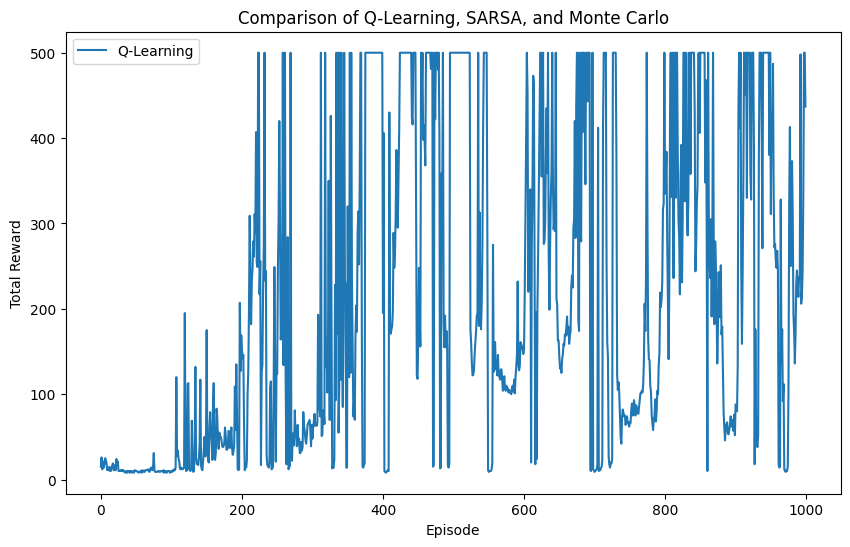

In [ ]:
# # Q-Learning
q_network = QNetwork(state_size, action_size)
q_optimizer = optim.Adam(q_network.parameters(), lr=1e-3)
q_rewards = train_q_learning(env, q_network, q_optimizer, episodes=1000)

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(q_rewards, label='Q-Learning')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Q-Learning, SARSA, and Monte Carlo')
plt.legend()
plt.show()

### SARSA

Update Rule (Per Time Step):

SARSA (**State-Action-Reward-State-Action**) is an **on-policy** algorithm. Unlike Q-Learning, which uses the greedy **max** action for the next state, SARSA follows the same **policy** that is being learned (e.g., $\epsilon$-greedy policy).

The update rule for SARSA is:

$$
y = r + \gamma Q_{\theta}(s', a')
$$

The loss function remains the same:

$$
L(\theta) = \left(y - Q_{\theta}(s, a)\right)^2
$$

where the parameters $\theta$ are updated via **gradient descent**.

In [ ]:
# 5. SARSA Implementation

def sarsa_update(network, optimizer, state, action, reward, next_state, next_action, done, gamma=0.99):
    # The loss function for SARSA minimizes the squared difference between the target value y and the predicted Q-value Q_{\theta}(s, a):
    # Take gradient descent step to update the network parameters.
    # Return the loss.
    # FILL ME IN

    # Convert state to tensor and get Q-values
    state_tensor = torch.FloatTensor(state).unsqueeze(0)
    q_values = network(state_tensor)

    # Convert next_state to tensor and get Q-values
    next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
    with torch.no_grad():
        q_values_next = network(next_state_tensor)

    if done:
      y = reward
    else:
      y = reward + gamma * torch.squeeze(q_values_next)[next_action]
      y = y.detach()

    # update
    optimizer.zero_grad()

    loss = (y - torch.squeeze(q_values)[action]) ** 2

    loss.backward()
    optimizer.step()

    return loss


def train_sarsa(env, network, optimizer, episodes=500, gamma=0.99,
                epsilon_start=1.0, epsilon_end=0.01, decay=500):
    rewards_history = []
    steps_done = 0

    for ep in range(episodes):
        state = env.reset()
        done = False

        # Choose initial action
        epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))
        q_values = network(torch.FloatTensor(state))
        action = epsilon_greedy_policy(q_values, epsilon)

        episode_reward = 0

        while not done:
            next_state, reward, done, info = env.step(action)

            epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))

            q_values = network(torch.FloatTensor(next_state))
            next_action = epsilon_greedy_policy(q_values, epsilon)

            loss = sarsa_update(network, optimizer, state, action, reward,
                                next_state, next_action, done, gamma)

            state = next_state
            action = next_action
            episode_reward += reward
            steps_done += 1

        rewards_history.append(episode_reward)

    return rewards_history


Train the SARSA algorithm.

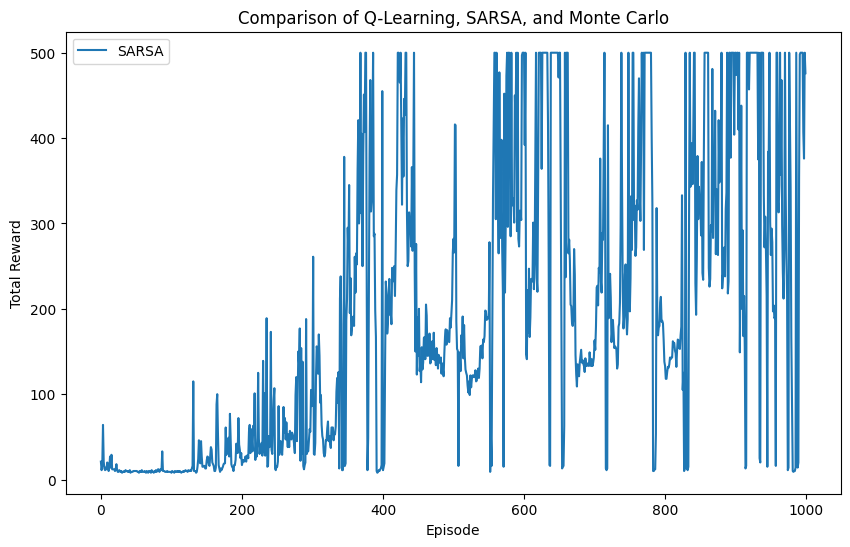

In [ ]:
# SARSA
sarsa_network = QNetwork(state_size, action_size)
sarsa_optimizer = optim.Adam(sarsa_network.parameters(), lr=1e-3)
sarsa_rewards = train_sarsa(env, sarsa_network, sarsa_optimizer, episodes=1000)

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(sarsa_rewards, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Q-Learning, SARSA, and Monte Carlo')
plt.legend()
plt.show()

### Monte Carlo Regression

Update Rule:

Monte Carlo (MC) learning estimates **Q-values** by running full episodes and using the **observed returns** to update the function approximator. Unlike Q-learning or SARSA, which update at each time step, Monte Carlo updates only **at the end of an episode**.

#### Steps:

1. **Generate an entire episode**:

   $$
   (s_0, a_0, r_1, s_1, a_1, r_2, \dots, s_{T-1}, a_{T-1}, r_T, s_T)
   $$

2. **For each state-action pair** \( (s_t, a_t) \), compute the return from that point onward:

   $$
   G_t = r_{t+1} + \gamma r_{t+2} + \dots + \gamma^{T-t-1} r_T
   $$

   where:
   - $ G_t $ is the **discounted return** from time step $ t $.
   - $ \gamma $ is the discount factor.
   - $ T $ is the length of the episode.

3. **Use gradient descent** to minimize the squared error between the estimated return \( G_t \) and the predicted Q-value \( Q_{\theta}(s_t, a_t) \):

   $$
   L(\theta) = \left(G_t - Q_{\theta}(s_t, a_t)\right)^2
   $$

### First-Visit vs. Every-Visit Monte Carlo
- **First-Visit MC**: Updates $ Q(s, a) $ **only the first time** each state-action pair is encountered in an episode.
- **Every-Visit MC**: Updates $ Q(s, a) $ **every time** the state-action pair appears in the episode.

In this implementation, we will use **every-visit MC** for simplicity.


In [ ]:
# 6. Monte Carlo Implementation

def train_monte_carlo(env, network, optimizer, episodes=500, gamma=0.99,
                      epsilon_start=1.0, epsilon_end=0.01, decay=500):
    rewards_history = []
    steps_done = 0

    for ep in range(episodes):
        # Generate an entire episode
        state = env.reset()
        done = False
        episode_experiences = []

        while not done:
            epsilon = max(epsilon_end, epsilon_start * (1 - steps_done / decay))
            # Implement the epsilon-greedy policy
            q_values = network(torch.FloatTensor(state))
            action = epsilon_greedy_policy(q_values, epsilon)

            next_state, reward, done, info = env.step(action)
            episode_experiences.append((state, action, reward))

            state = next_state
            steps_done += 1

        # Compute returns (G) for each state-action in the episode
        G = 0
        returns = []
        for t in reversed(range(len(episode_experiences))):
            s_t, a_t, r_t = episode_experiences[t]
            G = r_t + gamma * G
            returns.insert(0, G)

        episode_reward = sum([exp[2] for exp in episode_experiences])
        rewards_history.append(episode_reward)

        # MC updates (every-visit)
        for (s_t, a_t, _), G_t in zip(episode_experiences, returns):
            state_t = torch.FloatTensor(s_t).unsqueeze(0)
            q_values = network(state_t)
            q_value = q_values[0, a_t]

            target = torch.tensor([G_t], dtype=torch.float32)
            loss = (target - q_value)**2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return rewards_history


Train the Monte Carlo algorithm.

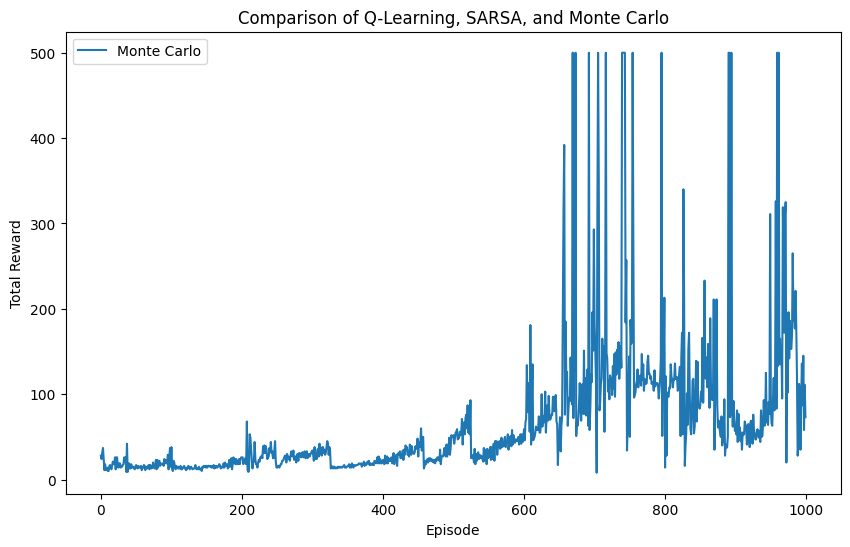

In [ ]:
# Monte Carlo
mc_network = QNetwork(state_size, action_size)
mc_optimizer = optim.Adam(mc_network.parameters(), lr=1e-3)
mc_rewards = train_monte_carlo(env, mc_network, mc_optimizer, episodes=1000)

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(mc_rewards, label='Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Q-Learning, SARSA, and Monte Carlo')
plt.legend()
plt.show()

### Comparing the Three Methods

Please run the following cell to compare the three methods.
Report the results and analysis in your writeup.

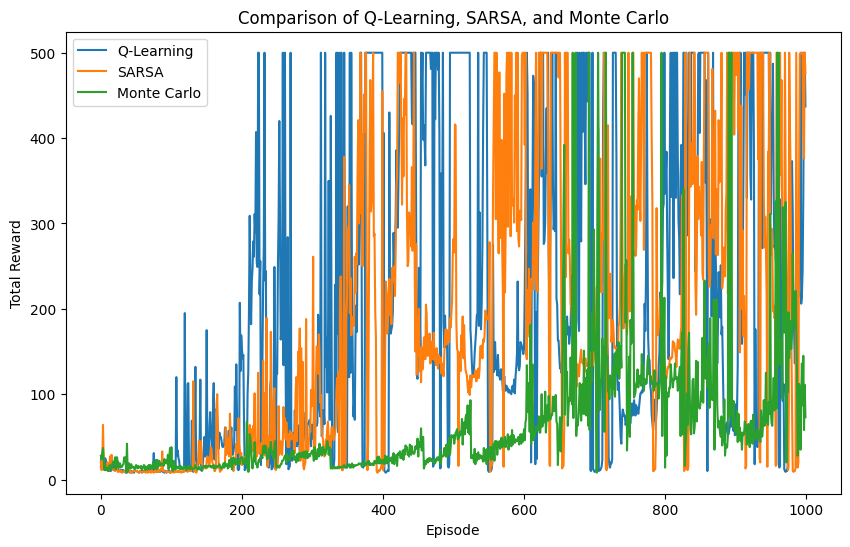

In [ ]:
# 7. Running & Comparing the Three Methods

# Plot learning curves
plt.figure(figsize=(10,6))
plt.plot(q_rewards, label='Q-Learning')
plt.plot(sarsa_rewards, label='SARSA')
plt.plot(mc_rewards, label='Monte Carlo')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Comparison of Q-Learning, SARSA, and Monte Carlo')
plt.legend()
plt.show()
